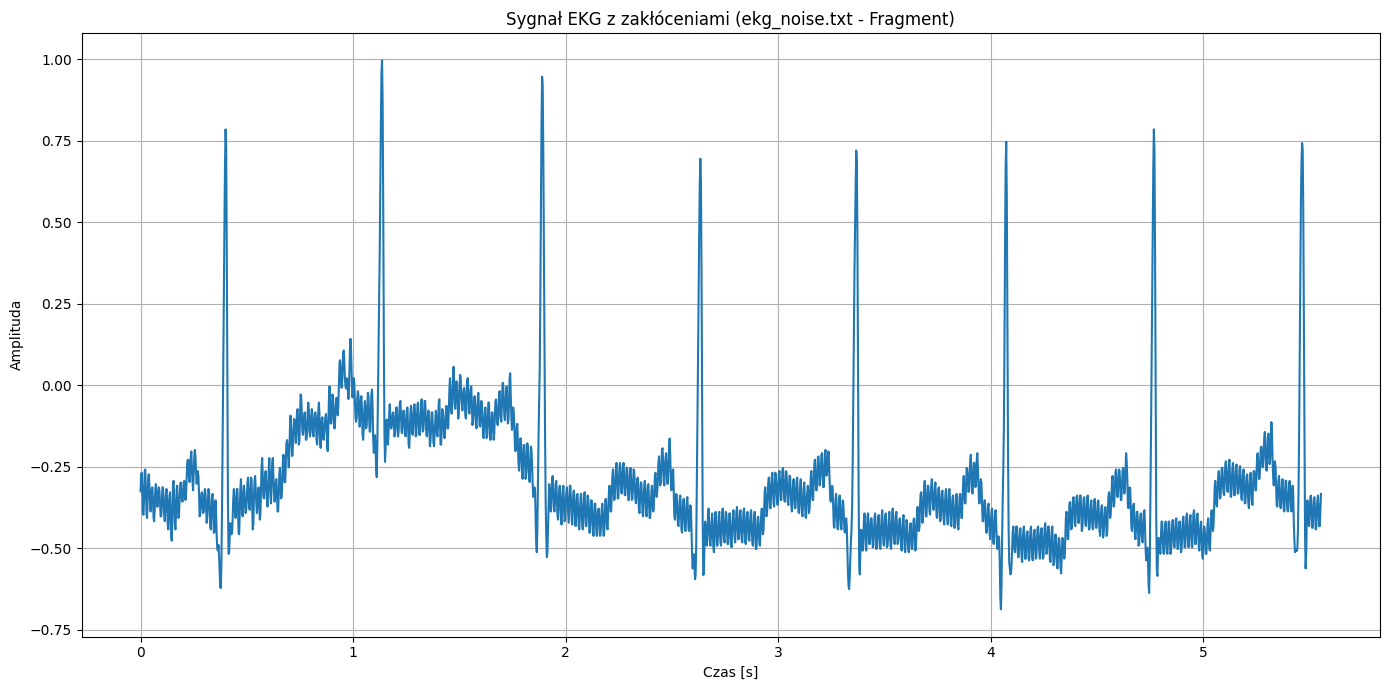

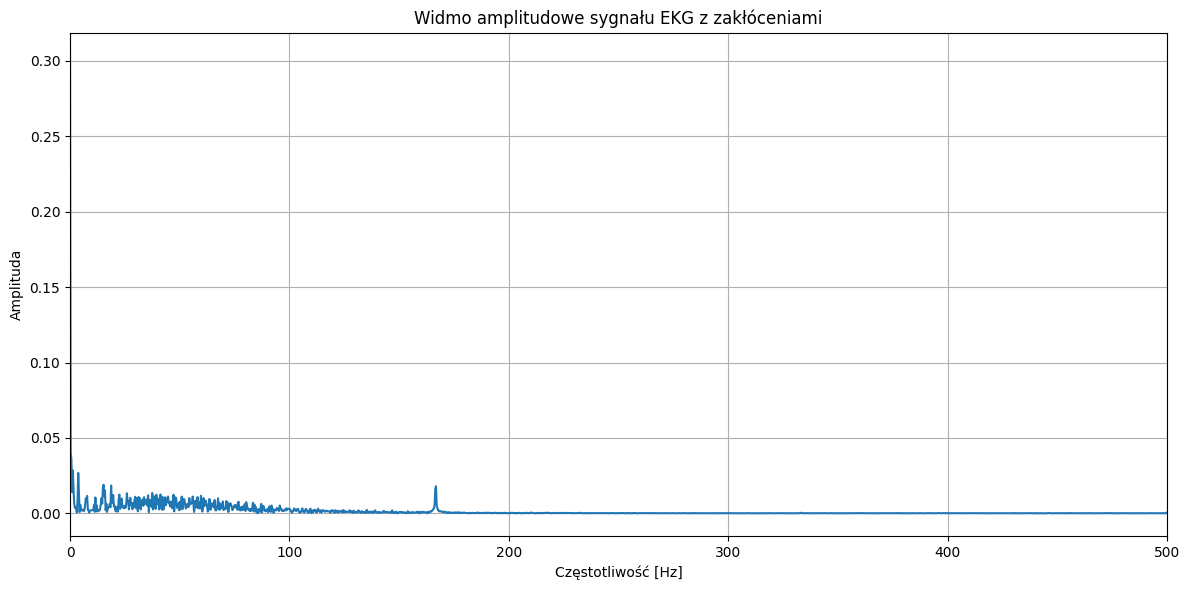

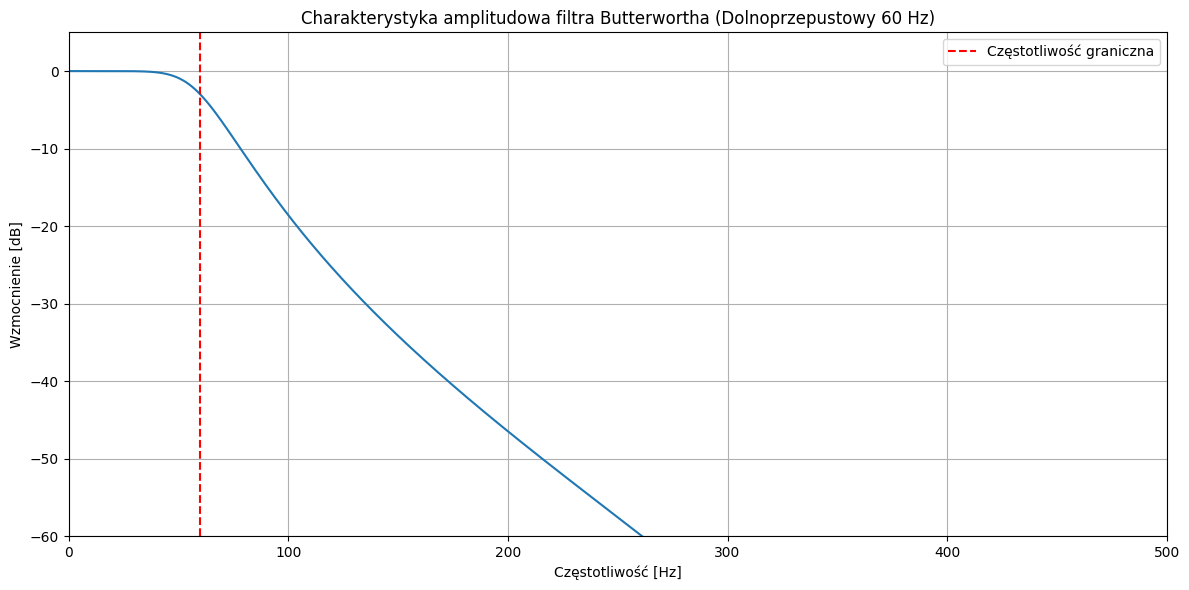

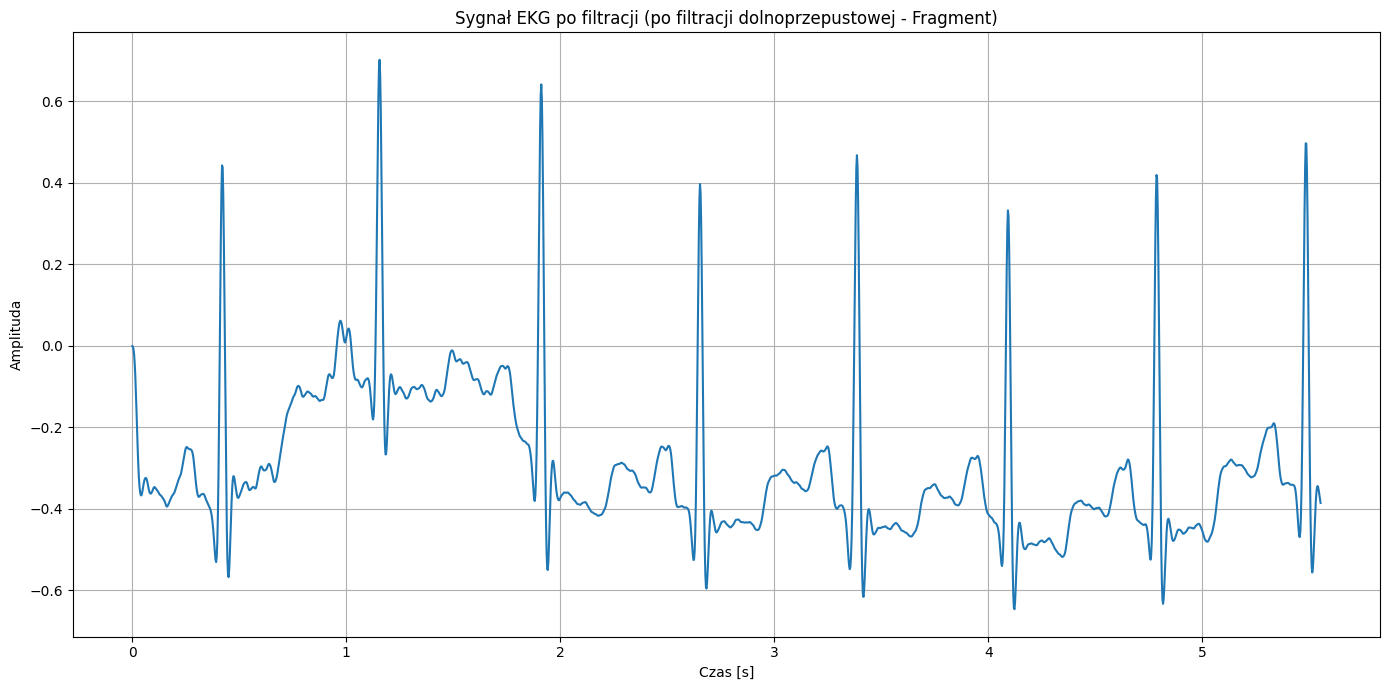

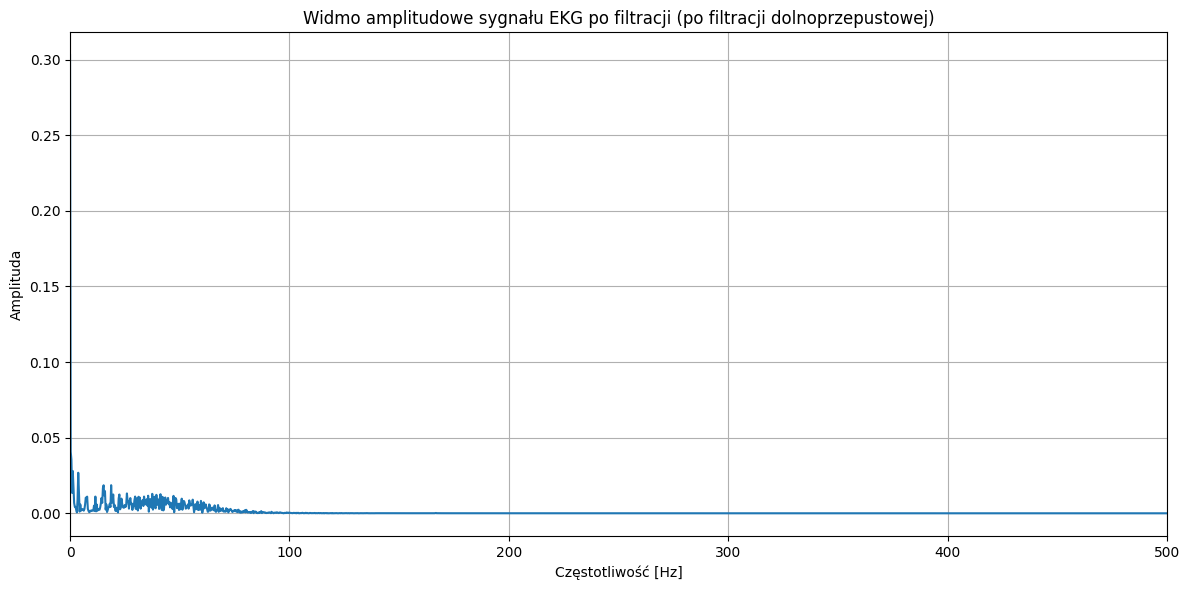

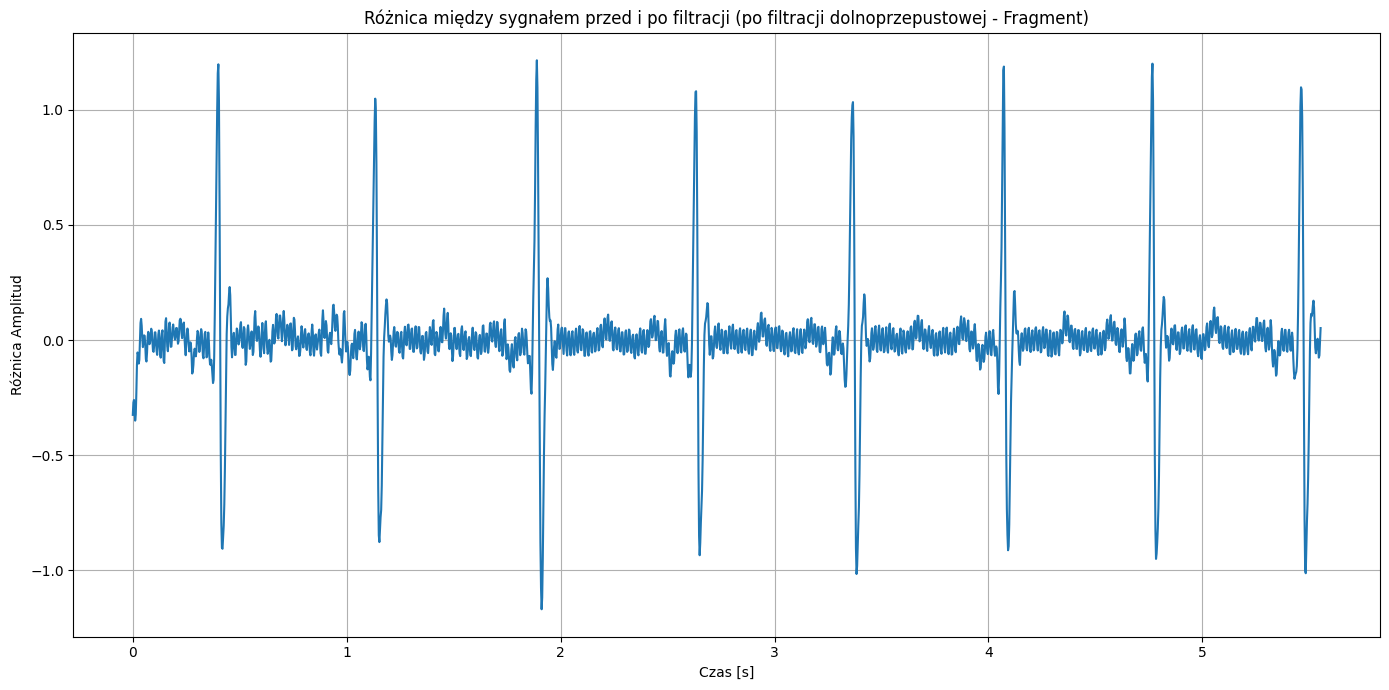

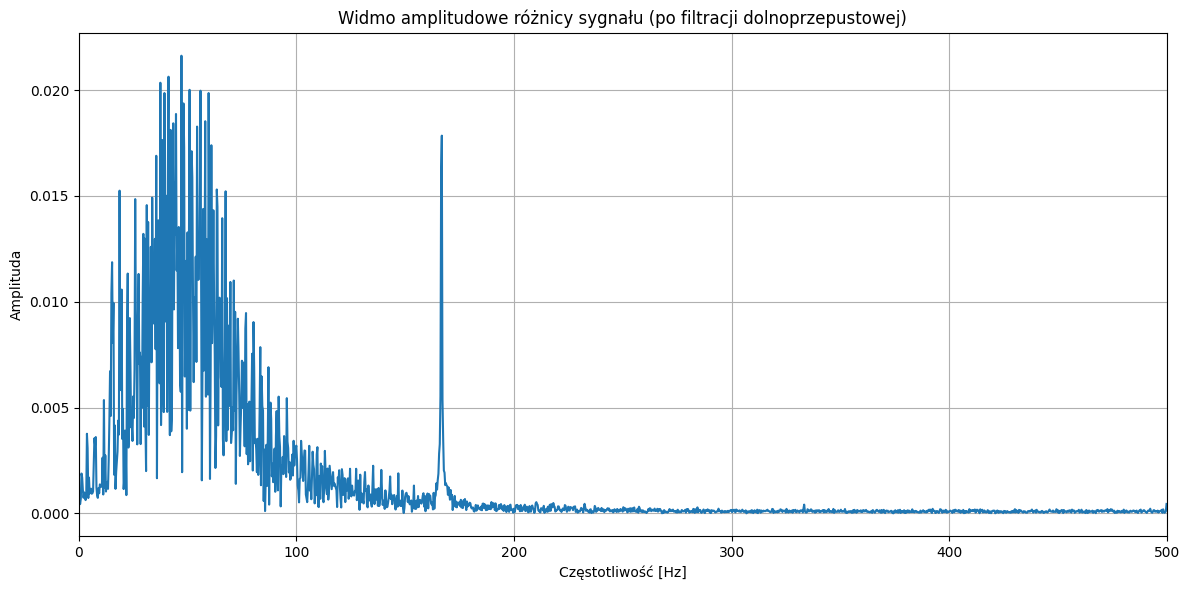

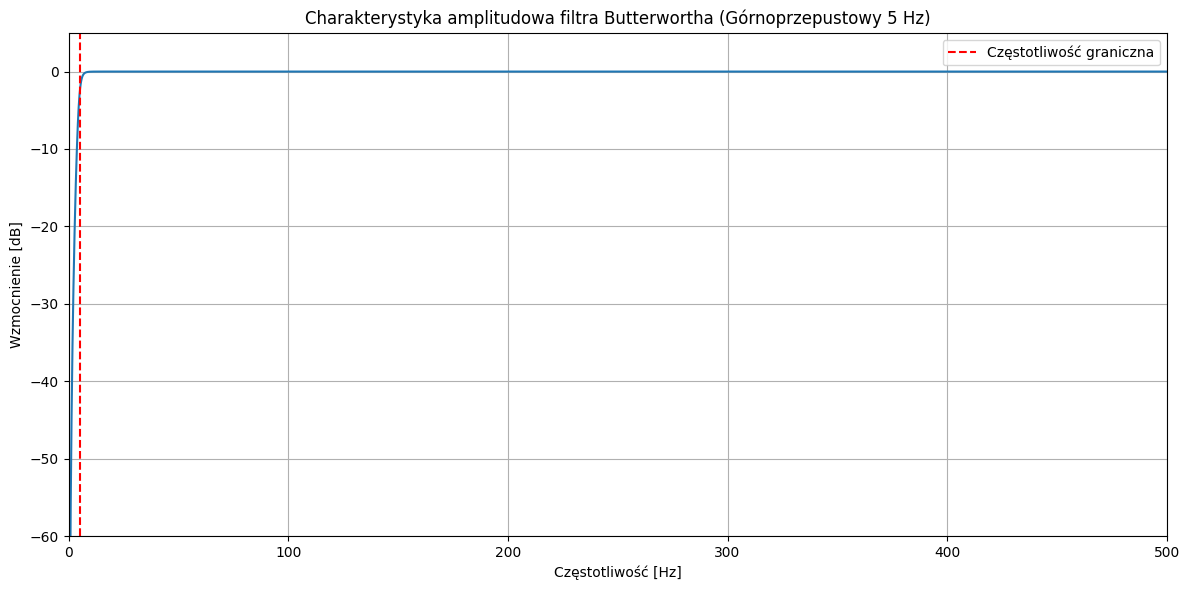

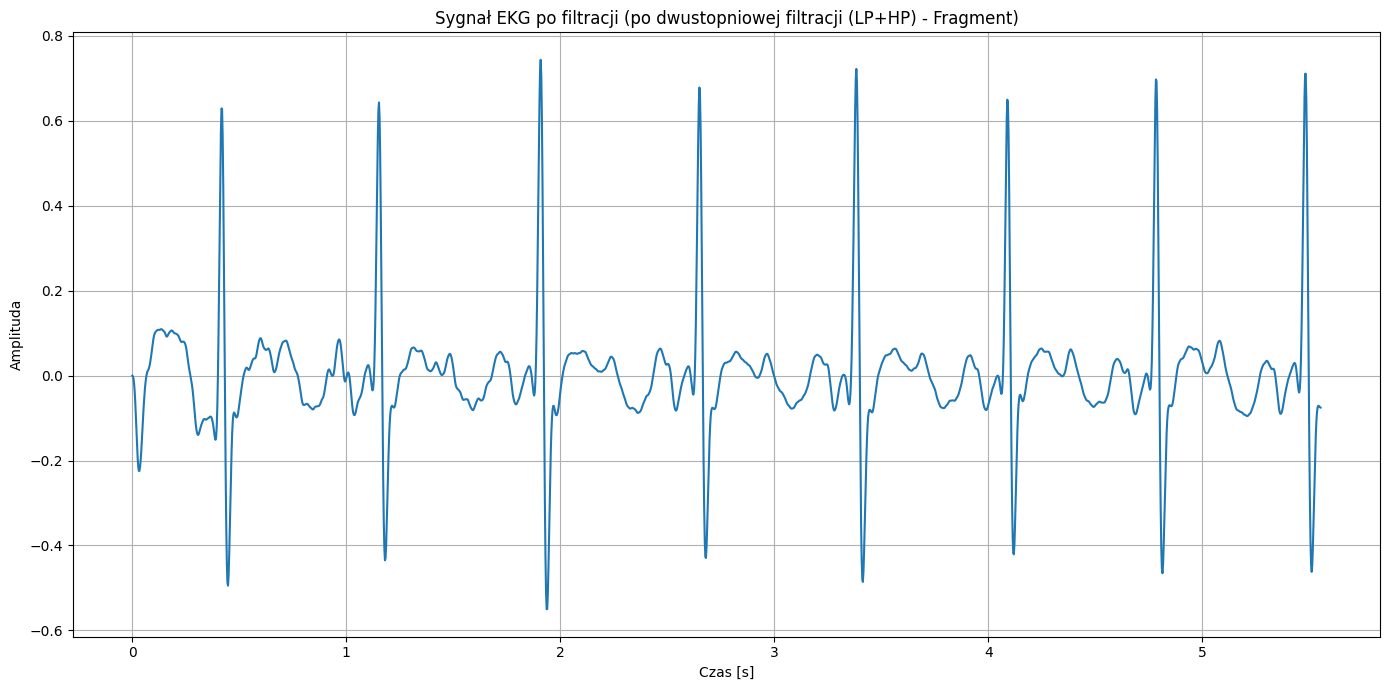

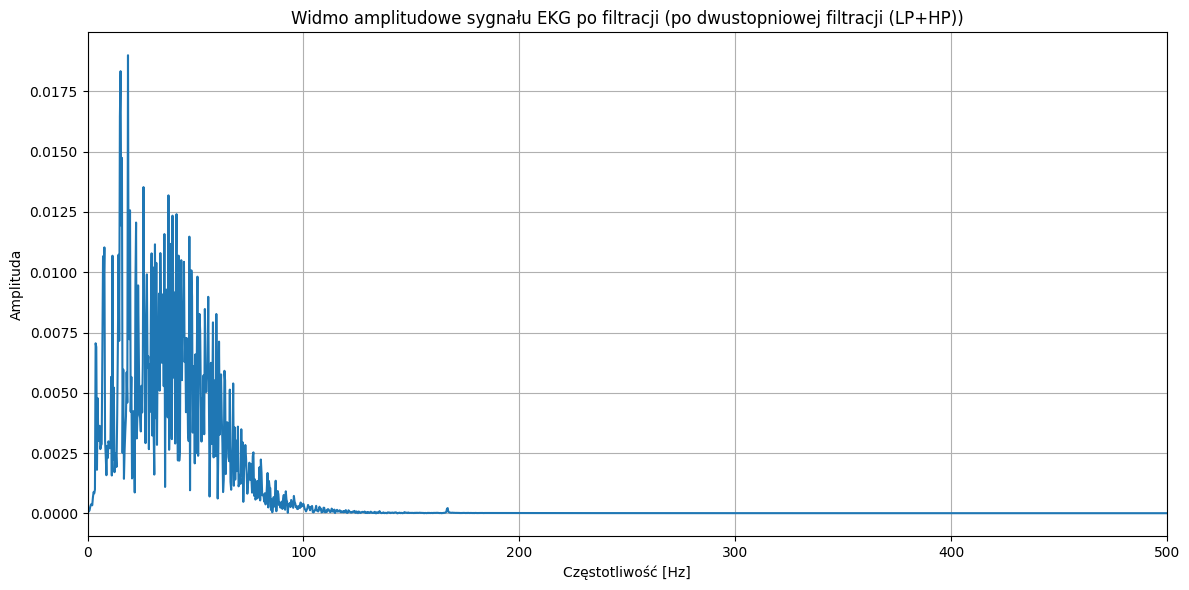

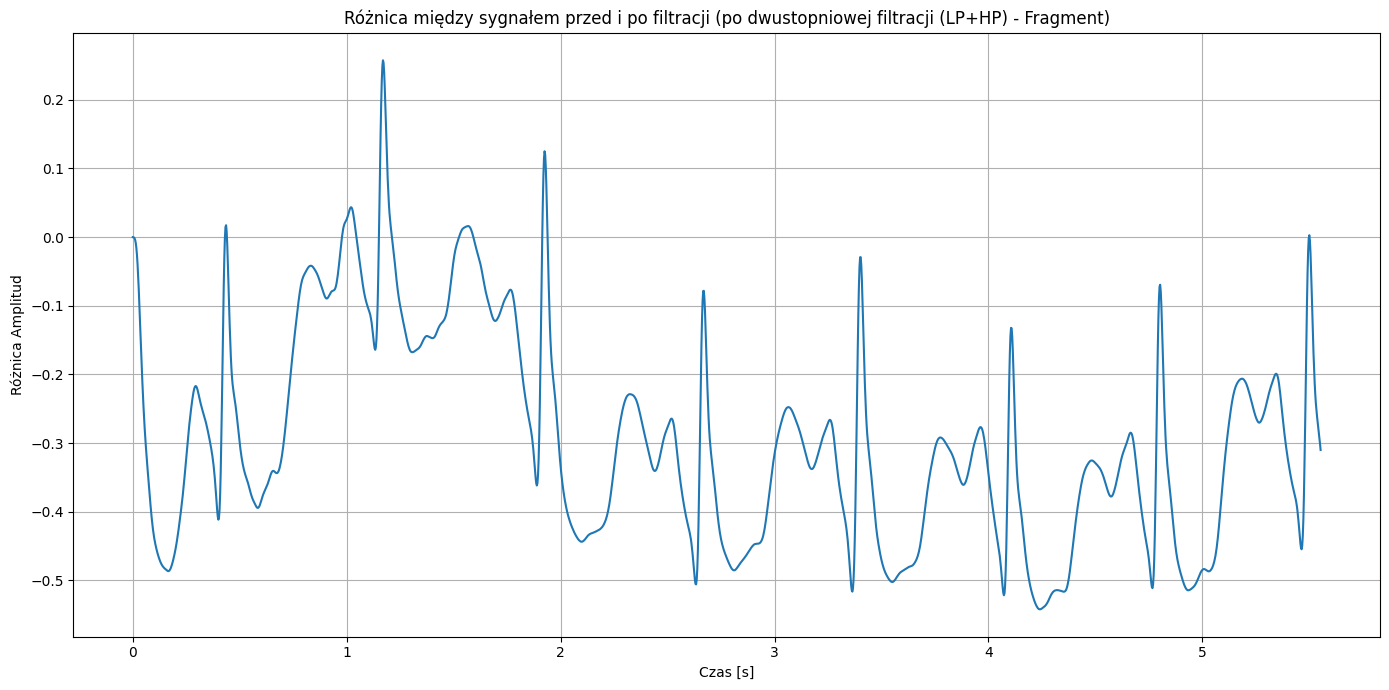

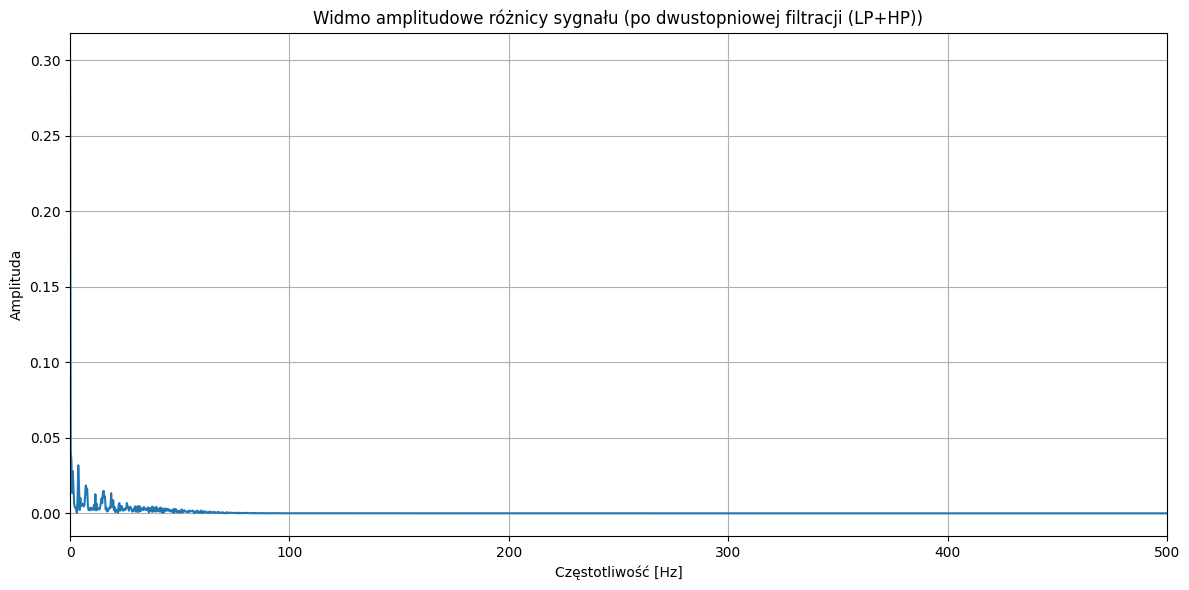

TypeError: unsupported operand type(s) for /: 'list' and 'float'

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

FILE_NAME = "ekg_noise.txt"
SAMPLING_RATE_EKG_NOISE = 1000

PLOT_SAMPLES_LIMIT = 2000
PLOT_DURATION_LIMIT = PLOT_SAMPLES_LIMIT / SAMPLING_RATE_EKG_NOISE

def load_ekg_noise_signal(file_name=FILE_NAME):
    try:
        data = np.loadtxt(f'sygnaly-testowe/{file_name}')
    except FileNotFoundError:
        return None, None, None

    time = data[:, 0]
    signal_data = data[:, 1]
    sampling_rate = SAMPLING_RATE_EKG_NOISE

    return time, signal_data, sampling_rate

def compute_and_plot_fft(signal_data, sampling_rate, title="Widmo amplitudowe sygnału"):
    N = len(signal_data)
    freqs = np.fft.fftfreq(N, 1 / sampling_rate)
    fft_values = np.fft.fft(signal_data)
    fft_magnitude = np.abs(fft_values) / N

    positive_freq_indices = np.where(freqs >= 0)
    freqs_positive = freqs[positive_freq_indices]
    fft_magnitude_positive = fft_magnitude[positive_freq_indices]

    plt.figure(figsize=(12, 6))
    plt.plot(freqs_positive, fft_magnitude_positive)
    plt.title(title)
    plt.xlabel("Częstotliwość [Hz]")
    plt.ylabel("Amplituda")
    plt.grid(True)
    plt.xlim(0, sampling_rate / 2)
    plt.tight_layout()
    plt.show()

def design_and_plot_filter_characteristics(filter_type, cutoff_freq, sampling_rate, order=4, title=""):
    nyquist = 0.5 * sampling_rate
    
    # Corrected normalization for bandpass filter
    if filter_type == 'bandpass':
        normalized_cutoff_freq = [f / nyquist for f in cutoff_freq] # Normalize each frequency in the list
    else:
        normalized_cutoff_freq = cutoff_freq / nyquist

    if filter_type == 'lowpass':
        b, a = signal.butter(order, normalized_cutoff_freq, btype='low', analog=False)
    elif filter_type == 'highpass':
        b, a = signal.butter(order, normalized_cutoff_freq, btype='high', analog=False)
    elif filter_type == 'bandpass':
        b, a = signal.butter(order, normalized_cutoff_freq, btype='band', analog=False)
    else:
        raise ValueError("Nieznany typ filtra.")

    w, h = signal.freqz(b, a, worN=8000)
    frequencies = nyquist * w / np.pi

    plt.figure(figsize=(12, 6))
    plt.plot(frequencies, 20 * np.log10(abs(h)))
    plt.title(f"Charakterystyka amplitudowa filtra Butterwortha ({title})")
    plt.xlabel("Częstotliwość [Hz]")
    plt.ylabel("Wzmocnienie [dB]")
    plt.grid(True)
    
    # Adjust axvline for bandpass to show both cutoffs
    if filter_type == 'bandpass':
        plt.axvline(x=cutoff_freq[0], color='r', linestyle='--', label=f'Częstotliwość graniczna {cutoff_freq[0]} Hz')
        plt.axvline(x=cutoff_freq[1], color='r', linestyle='--', label=f'Częstotliwość graniczna {cutoff_freq[1]} Hz')
    else:
        plt.axvline(x=cutoff_freq, color='r', linestyle='--', label='Częstotliwość graniczna')
    plt.legend()
    plt.xlim(0, sampling_rate / 2)
    plt.ylim(-60, 5)
    plt.tight_layout()
    plt.show()

    return b, a

def apply_filter_and_plot_results(original_time, original_signal, sampling_rate, b, a, step_description):
    filtered_signal = signal.lfilter(b, a, original_signal)

    plt.figure(figsize=(14, 7))
    plt.plot(original_time[:PLOT_SAMPLES_LIMIT], filtered_signal[:PLOT_SAMPLES_LIMIT])
    plt.title(f"Sygnał EKG po filtracji ({step_description} - Fragment)")
    plt.xlabel("Czas [s]")
    plt.ylabel("Amplituda")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    compute_and_plot_fft(filtered_signal, sampling_rate,
                         title=f"Widmo amplitudowe sygnału EKG po filtracji ({step_description})")

    difference_signal = original_signal - filtered_signal
    plt.figure(figsize=(14, 7))
    plt.plot(original_time[:PLOT_SAMPLES_LIMIT], difference_signal[:PLOT_SAMPLES_LIMIT])
    plt.title(f"Różnica między sygnałem przed i po filtracji ({step_description} - Fragment)")
    plt.xlabel("Czas [s]")
    plt.ylabel("Różnica Amplitud")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    compute_and_plot_fft(difference_signal, sampling_rate,
                         title=f"Widmo amplitudowe różnicy sygnału ({step_description})")

    return filtered_signal

if __name__ == "__main__":
    time_ekg, signal_ekg_noise, fs_ekg_noise = load_ekg_noise_signal()

    if signal_ekg_noise is None:
        pass
    else:
        plt.figure(figsize=(14, 7))
        plt.plot(time_ekg[:PLOT_SAMPLES_LIMIT], signal_ekg_noise[:PLOT_SAMPLES_LIMIT])
        plt.title(f"Sygnał EKG z zakłóceniami ({FILE_NAME} - Fragment)")
        plt.xlabel("Czas [s]")
        plt.ylabel("Amplituda")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        compute_and_plot_fft(signal_ekg_noise, fs_ekg_noise,
                             title="Widmo amplitudowe sygnału EKG z zakłóceniami")

        lowpass_cutoff = 60
        filter_order = 4

        b_lp, a_lp = design_and_plot_filter_characteristics(
            'lowpass', lowpass_cutoff, fs_ekg_noise, order=filter_order, title=f"Dolnoprzepustowy {lowpass_cutoff} Hz"
        )

        signal_after_lowpass = apply_filter_and_plot_results(
            time_ekg, signal_ekg_noise, fs_ekg_noise, b_lp, a_lp, "po filtracji dolnoprzepustowej"
        )

        highpass_cutoff = 5

        b_hp, a_hp = design_and_plot_filter_characteristics(
            'highpass', highpass_cutoff, fs_ekg_noise, order=filter_order, title=f"Górnoprzepustowy {highpass_cutoff} Hz"
        )

        signal_final_filtered = apply_filter_and_plot_results(
            time_ekg, signal_after_lowpass, fs_ekg_noise, b_hp, a_hp, "po dwustopniowej filtracji (LP+HP)"
        )

        bandpass_cutoff = [highpass_cutoff, lowpass_cutoff]
        b_bp, a_bp = design_and_plot_filter_characteristics(
            'bandpass', bandpass_cutoff, fs_ekg_noise, order=filter_order, title=f"Pasmowoprzepustowy [{highpass_cutoff}, {lowpass_cutoff}] Hz"
        )
        signal_bandpass_filtered = signal.lfilter(b_bp, a_bp, signal_ekg_noise)

        plt.figure(figsize=(14, 7))
        plt.plot(time_ekg[:PLOT_SAMPLES_LIMIT], signal_final_filtered[:PLOT_SAMPLES_LIMIT], label="Filtracja szeregowa (LP+HP)")
        plt.plot(time_ekg[:PLOT_SAMPLES_LIMIT], signal_bandpass_filtered[:PLOT_SAMPLES_LIMIT], label="Filtr pasmowoprzepustowy", linestyle='--')
        plt.title("Porównanie filtracji szeregowej z filtrem pasmowoprzepustowym (Fragment)")
        plt.xlabel("Czas [s]")
        plt.ylabel("Amplituda")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        compute_and_plot_fft(signal_bandpass_filtered, fs_ekg_noise,
                             title=f"Widmo amplitudowe sygnału EKG po filtracji pasmowoprzepustowej [{highpass_cutoff}, {lowpass_cutoff}] Hz")